In [1]:
## Imports
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path

from facet_ml.classification import mask_rcnn

In [2]:
# Coco folder
coco_dir = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\ProcessedData\Coco_v5\train"

cd = mask_rcnn.ManualCocoColloidalDataset(coco_dir, str(Path(coco_dir) / "_annotations.coco.json"))

In [3]:
for ii in range(len(cd)):
    image, targets = cd[ii]
    print(image.shape)
    for k,v in targets.items():
        print(f"{k} : {np.shape(v)}")
    print()
# targets

c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\tv_tensors\_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


torch.Size([3, 1024, 1280])
boxes : torch.Size([27, 4])
labels : torch.Size([27])
image_id : torch.Size([1])
masks : torch.Size([27, 1024, 1280])

torch.Size([3, 1024, 1280])
boxes : torch.Size([101, 4])
labels : torch.Size([101])
image_id : torch.Size([1])
masks : torch.Size([101, 1024, 1280])

torch.Size([3, 1024, 1280])
boxes : torch.Size([133, 4])
labels : torch.Size([133])
image_id : torch.Size([1])
masks : torch.Size([133, 1024, 1280])

torch.Size([3, 1024, 1280])
boxes : torch.Size([30, 4])
labels : torch.Size([30])
image_id : torch.Size([1])
masks : torch.Size([30, 1024, 1280])



In [4]:
def collate_fn(batch):
    '''
    Collation function receives [(image_1, targets_1{masks,boxes,labels}), (image_10, targets_1{masks,boxes,labels})...]
    Need to stack image_1
    '''
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    # return tuple(zip(*batch))
    return images,targets

train_loader = DataLoader(cd,
        batch_size=1,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn,
        pin_memory=False
        )

In [5]:
next(iter(train_loader))

([tensor([[[0.3529, 0.3529, 0.3529,  ..., 0.3569, 0.3569, 0.3608],
           [0.3529, 0.3529, 0.3529,  ..., 0.3569, 0.3569, 0.3608],
           [0.3529, 0.3529, 0.3529,  ..., 0.3569, 0.3569, 0.3608],
           ...,
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
  
          [[0.3529, 0.3529, 0.3529,  ..., 0.3569, 0.3569, 0.3608],
           [0.3529, 0.3529, 0.3529,  ..., 0.3569, 0.3569, 0.3608],
           [0.3529, 0.3529, 0.3529,  ..., 0.3569, 0.3569, 0.3608],
           ...,
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
  
          [[0.3529, 0.3529, 0.3529,  ..., 0.3569, 0.3569, 0.3608],
           [0.3529, 0.3529, 0.3529,  ..., 0.3569, 0.3569, 0.3608],
           [0.3529, 0.

In [6]:


# Assuming that the dataset is properly formatted and returns the required data.
# It should return a dictionary with the following keys:
# - 'image': a tensor of shape [3, H, W] representing the input image
# - 'boxes': a tensor of shape [N, 4] where N is the number of objects, and each box is (xmin, ymin, xmax, ymax)
# - 'labels': a tensor of shape [N] where N is the number of objects (background is not included)
# - 'masks': a tensor of shape [N, H, W] where N is the number of objects and each mask corresponds to the object

# Model creation
def create_maskrcnn_model(num_classes):
    # Load the backbone
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    # Create Mask R-CNN model with the backbone
    model = MaskRCNN(backbone, num_classes=num_classes)
    return model

# Create the model
num_classes = 2  # Example: 1 class (object) + 1 background
model = create_maskrcnn_model(num_classes)

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# Assuming `train_loader` is the DataLoader that provides batches of data
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    for i, (images, targets) in enumerate(data_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if i % print_freq == 0:
            print(f"Epoch [{epoch}], Iter [{i}/{len(data_loader)}], Loss: {losses.item():.4f}")
    
    # Step the learning rate scheduler after each epoch
    lr_scheduler.step()

# Training loop
num_epochs = 30  # Number of epochs to train for
for epoch in range(num_epochs):
    loss_dict = train_one_epoch(model, optimizer, train_loader, device, epoch)

# Save the trained model
torch.save(model.state_dict(), "maskrcnn_model.pth")


c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0], Iter [0/4], Loss: 5.6962
Epoch [1], Iter [0/4], Loss: 2.5661


KeyboardInterrupt: 

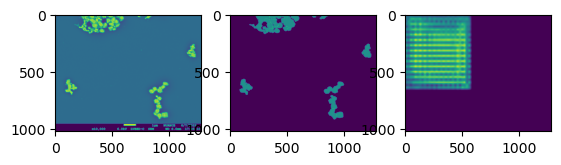

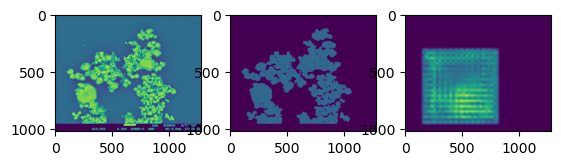

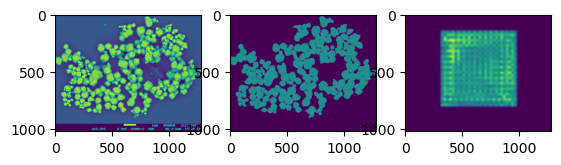

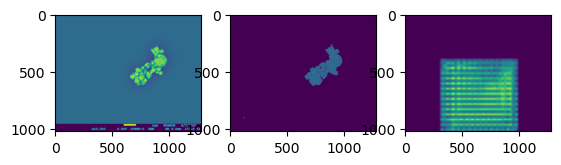

In [8]:
model.eval()
img_id = 0
import matplotlib.pyplot as plt
for img,targets in cd:
    # Get output
    out = model(list([img.to("cuda")]))

    fig, axes = plt.subplots(ncols=3)

    axes[0].imshow(img[0,:,:])
    axes[1].imshow(np.sum( np.array(targets["masks"]),axis=0))
    axes[2].imshow(np.sum(np.array(out[0]["masks"].to("cpu").detach().numpy())[0,:,:],axis=0))
out = model(list([cd[img_id][0].to("cuda")]))

import matplotlib.pyplot as plt

In [8]:
np.shape(cd[0][0])

torch.Size([3, 1024, 1280])

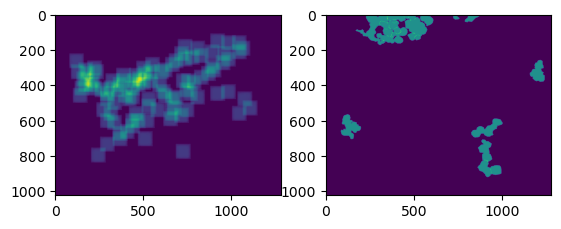

In [15]:
pred_masks = out[0]["masks"]
combined = np.sum(np.array(pred_masks.to("cpu").detach().numpy()),axis=0)
## Note:#3###3333

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(combined[0,:,:])
axes[1].imshow(np.sum( np.array(cd[img_id][1]["masks"]),axis=0))

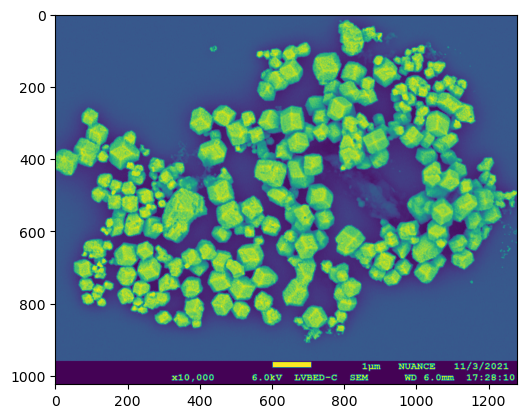

In [10]:
plt.imshow(cd[2][0][0,:,:])

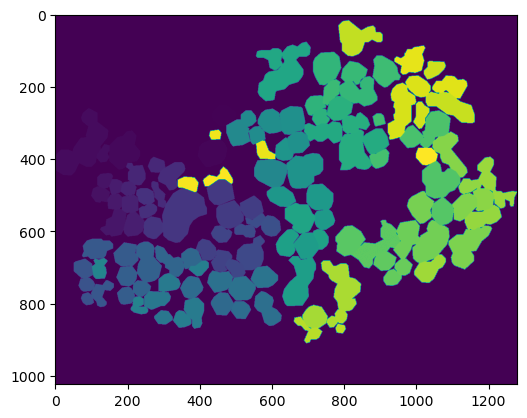

In [11]:
total_masks = np.array(cd[2][1]["masks"])
weighted_masks = np.array([total_masks[ii]*ii+1 for ii in range(total_masks.shape[0])])
combined_masks = np.max(weighted_masks,axis=0)
plt.imshow(combined_masks)

In [12]:
cd.coco["categories"], cd.coco["annotations"][0]
for ann in cd.coco["annotations"]:
    if ann["category_id"] == 2:
        print(ann)

{'id': 27, 'image_id': 0, 'category_id': 2, 'bbox': [255, 104, 6.278, 10.918], 'area': 68.54, 'segmentation': [[256.299, 103.993, 259.574, 107.815, 261.212, 112.455, 257.663, 114.911, 254.934, 114.911, 255.48, 111.636, 256.299, 108.088]], 'iscrowd': 0}
{'id': 28, 'image_id': 0, 'category_id': 2, 'bbox': [261, 42, 6.005, 7.097], 'area': 42.615, 'segmentation': [[263.668, 49.131, 262.03, 46.128, 261.212, 42.034, 264.76, 44.218, 267.216, 47.493]], 'iscrowd': 0}
{'id': 29, 'image_id': 1, 'category_id': 2, 'bbox': [0, 3, 1279.997, 957.396], 'area': 1225464.199, 'segmentation': [[1279.997, 959.414, 1278.75, 5, 683.75, 2.5, 0, 6.25, 1.25, 955, 223.75, 957.5, 235, 951.25, 235, 928.75, 211.25, 912.5, 188.75, 927.5, 161.25, 927.5, 160, 898.75, 142.5, 873.75, 142.5, 863.75, 153.75, 857.5, 163.75, 855, 188.75, 865, 201.25, 852.5, 223.75, 842.5, 237.5, 858.75, 232.5, 878.75, 236.25, 882.5, 261.25, 882.5, 267.5, 878.75, 270, 871.25, 267.5, 861.25, 245, 836.25, 248.75, 832.5, 261.25, 832.5, 268.75, 8